# Linear elasticity in a multipatch domain

In [83]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\MHeig\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['rc', 'f', 'bmat']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [84]:
p = 2  # spline degree 
n_el = (50, 10)   # number of elements in y/x direction, isotropic material
#n_el = (50, 20)   # number of elements in y/x direction
# displacement space: degree p,   continuity p-1
kvs = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=1) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs)


In [85]:
# define geometry map

geos = [
    geometry.quarter_annulus(),
    geometry.quarter_annulus().rotate_2d(3*pi/2),
    geometry.quarter_annulus().rotate_2d(pi),
    geometry.quarter_annulus().rotate_2d(pi/2)
]

patches = [(kvs, g) for g in geos]

#print(kvs)

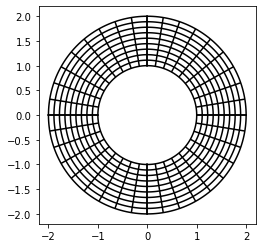

In [86]:
for g in geos:
    vis.plot_geo(g)
axis('scaled');

In [87]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

In [88]:
def A11_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()
    
    grad_uv= inner(grad(u), grad(v))
    div_11 = Dx(u,0) * Dx(v,0)
    
    vf.add(Mu * ( grad_uv +  div_11) * dx )
    return vf

def A12_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()
    
    div_21 = Dx(u,0) * Dx(v,1)
    
    vf.add(Mu * div_21 * dx )
    return vf

           
def A21_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()

    grad_uv= inner(grad(u), grad(v))
    div_12 = Dx(u,1) * Dx(v,0)
    
    vf.add( Mu * div_12 * dx)
    return vf
           
def A22_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()

    grad_uv= inner(grad(u), grad(v))
    div_22 = Dx(u,1) * Dx(v,1)
    
    vf.add(Mu * ( grad_uv +  div_22) * dx )
    return vf

def B1_vf(dim):
    from pyiga.vform import VForm, dx, Dx
    vf = VForm(dim)
    u, p = vf.basisfuns()
    vf.add( - Dx(u,0) * p * dx)
    return vf

def B2_vf(dim):
    from pyiga.vform import VForm, dx, Dx
    vf = VForm(dim)
    u, p = vf.basisfuns()
    vf.add( - Dx(u,1) * p * dx)
    return vf

def C_vf(dim):
    from pyiga.vform import VForm, dx
    vf = VForm(dim)
    p,q= vf.basisfuns()
    vf.add( -(1/Lam) * p * q * dx)
    return vf


In [89]:
# source term f 
f = lambda x,y: (0.0) # source term

In [90]:
#Neumann BC
def g_N(x, y): return (3e-5) # Neumann BC function # positive measure!

# set inhom. Neumann cond. on distal end, hom. NBC elsewhere
neu_data = [
    #(0, 'top', g),
    #(0,'right', g_N),
    #(1,'right', g_N),
    #(2,'right', g_N) 
    (3,'right', g_N) 
]

MP = assemble.Multipatch(patches, {'N':neu_data}, automatch=True) # physical!
#MP = assemble.Multipatch(patches, automatch=True) # without Neumann! 

In [91]:
#A, rhs, N = MP.assemble_system(linelast_vf(2), vform.L2functional_vf(2, physical=True), f=f)

A11, rhs1, nbc11 = MP.assemble_system(A11_vf(2), vform.L2functional_vf(2, physical=True), f=f)
A12, rhs12, nbc12 = MP.assemble_system(A12_vf(2), vform.L2functional_vf(2, physical=True), f=f) 
A21, rhs21, nbc21 = MP.assemble_system(A21_vf(2), vform.L2functional_vf(2, physical=True), f=f) 
A22, rhs2, nbc22 = MP.assemble_system(A22_vf(2), vform.L2functional_vf(2, physical=True), f=f)

B1, rb1, nb1 = MP.assemble_system(B1_vf(2), vform.L2functional_vf(2, physical=True), f=f)
B2, rb2, nb2 = MP.assemble_system(B2_vf(2), vform.L2functional_vf(2, physical=True), f=f)
C, rc, nc = MP.assemble_system(C_vf(2), vform.L2functional_vf(2, physical=True), f=f)


A = bmat([[A11, A12, B1.T], [A12.T, A22, B2.T], [B1, B2, C]])

print(shape(A))


(7344, 7344)


In [92]:
#print(shape(C)[0])

In [93]:
rhs= np.hstack((rhs1,rhs2)) # F= (f,f) 
rhs = np.pad(rhs, (0,shape(C)[0])) # (F,G)
print(shape(rhs))

#combine Neumann-BC to appropriate shape
#nbc= np.hstack((nbc11 +nb1, nbc22+nb2, nb1+nb2+nc)) 
nbc= np.hstack((np.zeros(shape(nbc11)), nbc22,)) ## in y-dir only
nbc = np.pad(nbc, (0,shape(C)[0])) 
print(shape(nbc))

(7344,)
(7344,)


In [94]:
# Dirichlet BC
# Dirichlet boundary function g
def g_zero(x, y): return (0.0) 

# set up Dirichlet boundary conditions
# vectorize bcs
bcs = MP.compute_dirichlet_bcs_vec([
    (1, 'right', g_zero)
])

print(shape(bcs))
#print(bc)

(2, 104)


In [95]:
# set up and solve linear system
LS = assemble.RestrictedLinearSystem(A, rhs +nbc, bc) #
u = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

#print(shape(u))
print(u)


[ 8.85718357e-03  8.79880656e-03  8.96552744e-03 ... -5.66028274e-07
  2.85891585e-07 -1.31660503e-06]


In [96]:
#print(MP.numdofs) # global dofs (=all dofs interface dofs,i.e. 2x16-4 = 28)
#print(2*MP.numdofs) 

u1 = u[:MP.numdofs]
u2 = u[MP.numdofs:2*MP.numdofs]

#print('u1= ',u1)
#print(shape(u1))
#print('u2= ', u2)
#print(shape(u2))


In [97]:
# restrict solution to each individual patch
u1_funcs = [geometry.BSplineFunc(kvs, MP.global_to_patch(p) @ u1)
           for p in range(len(patches))]
u2_funcs = [geometry.BSplineFunc(kvs, MP.global_to_patch(p) @ u2)
           for p in range(len(patches))]


(-2.2, 2.0, -2.0, 2.130254442650164)

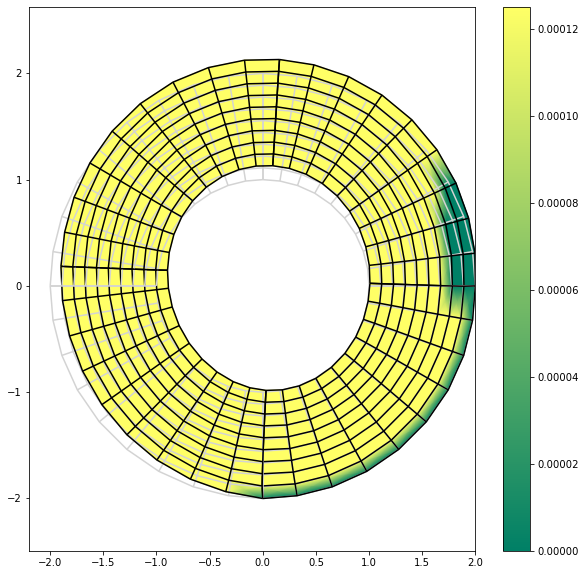

In [98]:
# set refinement steps for grid (visualization)
ref= 10

# evaluate displacement over a grid in the parameter domain
xgrid = linspace(0, 1, ref)
xygrid = (xgrid, xgrid)

figsize(10,10)
fig, ax = plt.subplots()
i=0
             
for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches): #u_funcs 
    #print(i)
    dis1= u1_func.grid_eval(xygrid)
    dis2 = u2_func.grid_eval(xygrid) 
    dis = np.stack((dis1,dis2), axis=-1)
    #print('dis=', dis)
    #print('dis1= ', dis1)
    #print(shape(dis1))
    #print('dis2= ', dis2)
    i+=1
    #print(dis2.min())
    #print(dis2.max())
    
    vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.25e-4)
    
    
colorbar();
axis('equal')
